In [1]:
# import libraries
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms as T
from torch.utils.data import DataLoader, Subset, TensorDataset, SubsetRandomSampler
from torchvision.datasets import FashionMNIST

import torchvision

import sys

import matplotlib.pyplot as plt

import tqdm

import pandas as pd

from typing import Sequence, Tuple, Optional, List

import torch_xla.core.xla_model as xm


In [2]:
import torch
import torch_xla

def get_best_device():
    try:
        return torch_xla.device()   # TPU
    except Exception:
        if torch.cuda.is_available():
            return torch.device("cuda:0")  # GPU
        else:
            return torch.device("cpu")     # CPU

device = get_best_device()
print("Using device:", device)

Using device: xla:0


# Import and Process Data

In [3]:
# transformations
transform = T.Compose([ T.Resize(64),
                        T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])

# import the data and simultaneously apply the transform
dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)


# transform to dataloaders
batchsize   = 128
data_loader = DataLoader(
                          dataset=dataset,
                          batch_size=batchsize,
                          shuffle=True,
                          drop_last=True,
                          num_workers=max(2,os.cpu_count()//2),
                          pin_memory=True,
                          persistent_workers=True,
                          prefetch_factor=2
                          )

In [4]:
len(data_loader)

390

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


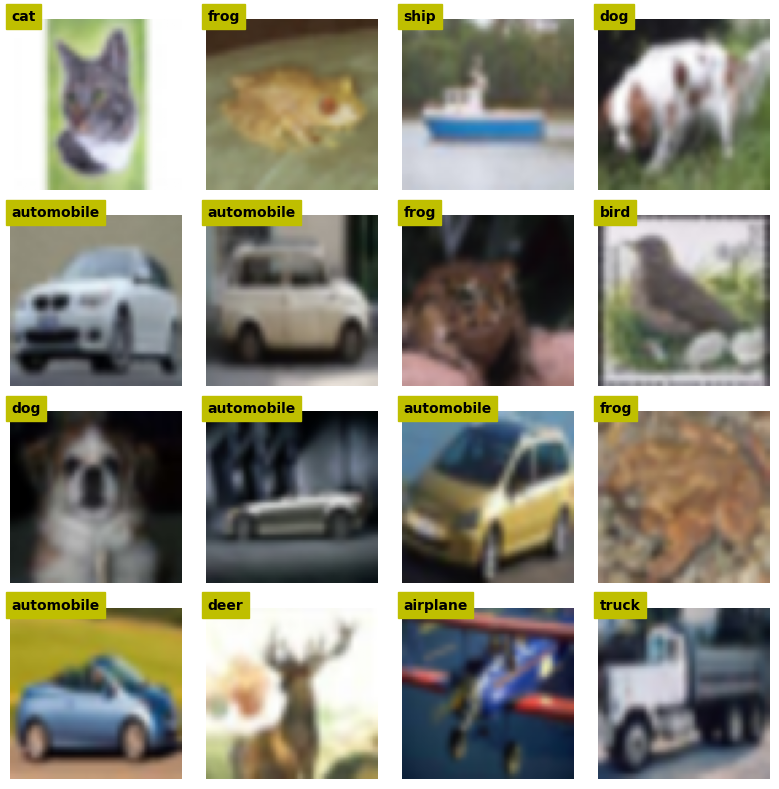

In [5]:
# inspect a few random images

X,y = next(iter(data_loader))

fig,axs = plt.subplots(4,4,figsize=(8,8))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = dataset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(0,0,label,ha='left',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show();

# Create classes for the discriminator and generator

In [6]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.Conv2d(  3, 64, 4, 2, 1, bias=False)
    self.conv2 = nn.Conv2d( 64,128, 4, 2, 1, bias=False)
    self.conv3 = nn.Conv2d(128,256, 4, 2, 1, bias=False)
    self.conv4 = nn.Conv2d(256,512, 4, 2, 1, bias=False)
    self.conv5 = nn.Conv2d(512,  1, 4, 1, 0, bias=False)

    # batchnorm
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)

  def forward(self,x):
    x = F.leaky_relu( self.conv1(x) ,.2)
    x = F.leaky_relu( self.bn2(self.conv2(x)) ,.2)
    x = F.leaky_relu( self.bn3(self.conv3(x)) ,.2)
    x = F.leaky_relu( self.bn4(self.conv4(x)) ,.2)
    x = self.conv5(x) # The final layer does not have batchnorm or leaky relu before view
    return x.view(-1,1)


dnet = discriminatorNet()
y = dnet(torch.randn(1,3,64,64))
y.shape

torch.Size([1, 1])

torch.Size([10, 3, 64, 64])


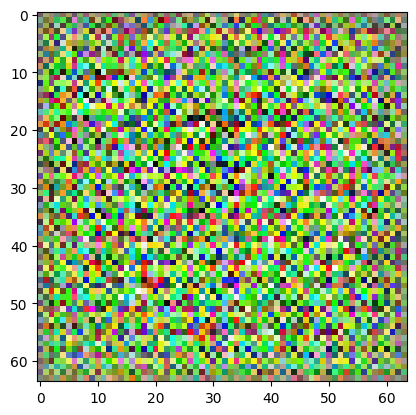

In [7]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.ConvTranspose2d(100,512, 4, 1, 0, bias=False)
    self.conv2 = nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False)
    self.conv3 = nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False)
    self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
    self.conv5 = nn.ConvTranspose2d(64,   3, 4, 2, 1, bias=False)

    # batchnorm
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d( 64)


  def forward(self,x):
    x = F.relu( self.bn1(self.conv1(x)) )
    x = F.relu( self.bn2(self.conv2(x)) )
    x = F.relu( self.bn3(self.conv3(x)) )
    x = F.relu( self.bn4(self.conv4(x)) )
    x = torch.tanh( self.conv5(x) )
    return x


gnet = generatorNet()
y = gnet(torch.randn(10,100,1,1))
print(y.shape)
pic = y[0,:,:,:].squeeze().detach().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
plt.imshow(pic);

# Train the DCGAN model

In [8]:
# Function to Initialize the DCGAN weights
def dcgan_weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if getattr(m, "bias", None) is not None:
            nn.init.zeros_(m.bias)

In [9]:
# Initialize the DCGAN weights
gnet.apply(dcgan_weights_init)
dnet.apply(dcgan_weights_init)

# Loss function
lossfun = nn.BCEWithLogitsLoss()

# Instantiate the networks
dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimization
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5,.999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5,.999))

In [10]:
len(data_loader)

390

In [11]:
device

device(type='xla', index=0)

In [12]:
from torch.amp import GradScaler
from time import time

use_cuda = torch.cuda.is_available()
scaler = GradScaler(enabled=use_cuda)

# number of epochs
num_epochs = 1

losses  = []
disDecs = []

start_time = time()

for epochi in range(num_epochs):

  for data,_ in data_loader:

    # send data to GPU
    data = data.to(device)

    # create labels for real and fake images
    real_labels = torch.ones(batchsize,1).to(device)
    fake_labels = torch.zeros(batchsize,1).to(device)



    ### ---------------- Train the discriminator ---------------- ###

    # forward pass and loss for REAL pictures
    pred_real   = dnet(data)                     # output of discriminator
    d_loss_real = lossfun(pred_real,real_labels) # all labels are 1

    # forward pass and loss for FAKE pictures
    fake_data   = torch.randn(batchsize,100,1,1).to(device) # random numbers to seed the generator
    with torch.no_grad():
      fake_images = gnet(fake_data)                      # output of generator
    pred_fake   = dnet(fake_images)                # pass through discriminator
    d_loss_fake = lossfun(pred_fake,fake_labels)            # all labels are 0

    # collect loss (using combined losses)
    d_loss = d_loss_real + d_loss_fake

    # backprop
    if use_cuda:
      scaler.scale(d_loss).backward()
      scaler.step(d_optimizer)
      scaler.update()
    else:
      d_optimizer.zero_grad()
      d_loss.backward()
      d_optimizer.step()



    ### ---------------- Train the generator ---------------- ###

    # create fake images and compute loss
    fake_images = gnet( torch.randn(batchsize,100,1,1).to(device) )
    pred_fake   = dnet(fake_images)

    # compute loss
    g_loss = lossfun(pred_fake,real_labels)

    # backprop
    if use_cuda:
      scaler.scale(g_loss).backward()
      scaler.step(g_optimizer)
      scaler.update()
    else:
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()


    # collect losses and discriminator decisions
    losses.append([d_loss.item(),g_loss.item()])

    d1 = torch.mean((pred_real>.5).float()).detach().cpu().item()
    d2 = torch.mean((pred_fake>.5).float()).detach().cpu().item()
    disDecs.append([d1,d2])

  elapsed_time = time() - start_time
  mins, secs = divmod(elapsed_time, 60)
  hours, mins = divmod(mins, 60)

  # print out a status message
  msg = f'Finished epoch {epochi+1}/{num_epochs} in {int(hours)}h:{int(mins)}m:{int(secs)}s'
  sys.stdout.write('\n' + msg)


# convert performance from list to numpy array
losses  = np.array(losses)
disDecs = np.array(disDecs)

KeyboardInterrupt: 

In [ ]:
# create a 1D smoothing filter
def smooth(x,k=15):
  return np.convolve(x,np.ones(k)/k,mode='same')

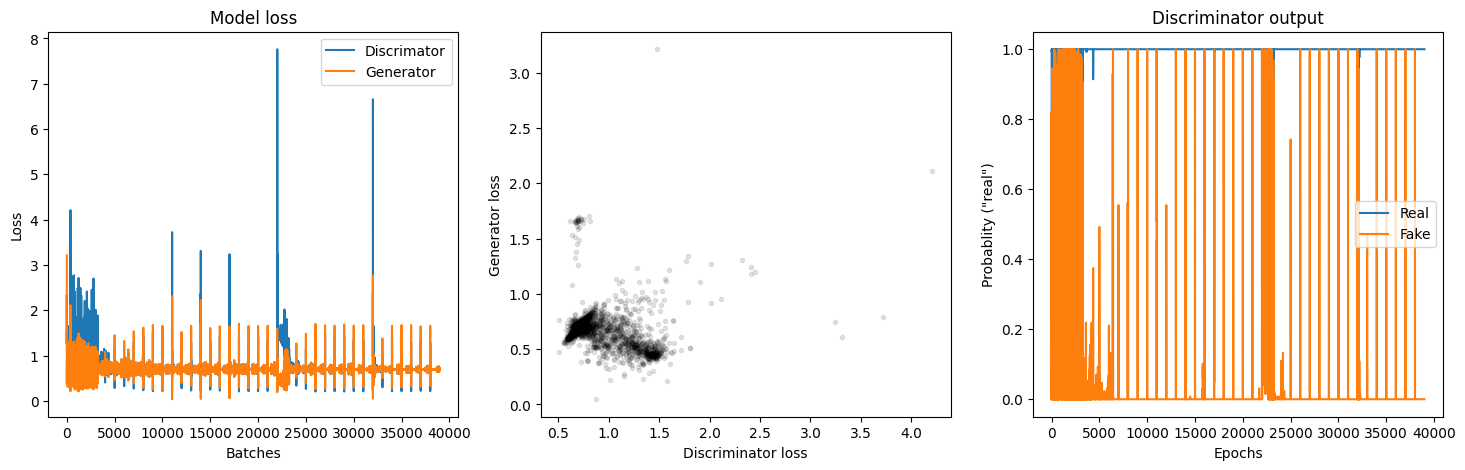

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

# ax[0].plot(smooth(losses[:,0]))
# ax[0].plot(smooth(losses[:,1]))
ax[0].plot(losses[:,0])
ax[0].plot(losses[:,1])
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([1500,2000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

# ax[2].plot(smooth(disDecs[:,0]))
# ax[2].plot(smooth(disDecs[:,1]))
ax[2].plot(disDecs[:,0])
ax[2].plot(disDecs[:,1])
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

# Visualize some pictures

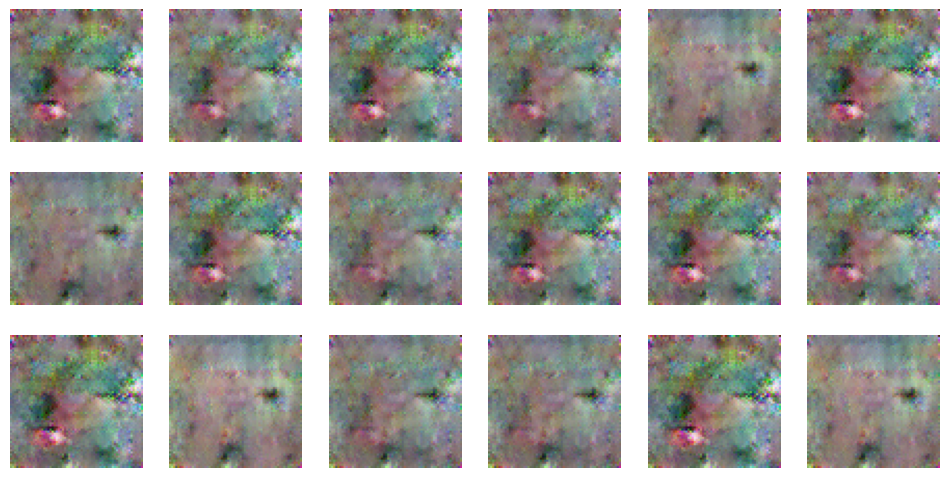

In [ ]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batchsize,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  pic = fake_data[i,:,].detach().squeeze().numpy().transpose((1,2,0))
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
  ax.imshow(pic)
  ax.axis('off')

plt.show();